In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [4]:
df_train.isnull().sum()

Id       0
Title    0
Body     0
Tags     8
dtype: int64

In [5]:
df_train = df_train.dropna()

In [6]:
# checking for duplicates

df_duplicated = df_train[df_train.duplicated(['Title','Body','Tags'], keep ='first')]
df_duplicated.head(10)

,Id,Title,Body,Tags
3550,3551,Compatibility issues with <a> and calling a fu...,<p>I am new to javascript. I wrote the followi...,function anchor
5246,5247,Using JTA with Spring +hibernate JPA+Glassfish...,<p>I have been struggling with this issues and...,spring hibernate jpa glassfish jta
9968,9969,Groovy Properties Assertion Fails,<p>Here is the content of my groovy file:</p>\...,properties groovy assert
10597,10598,Importance of isomorphic functions,<p><strong>Short Question:</strong> What is th...,functional-programming isomorphism
10939,10940,VB6 Form.Show is not working,<p>I have a project with graphs that can be pr...,forms vb6
13272,13273,"regular expression, find text inside couple of...",<p>i'm very new here and i hope i can explain ...,php regex arrays brackets curly-braces
13652,13653,How to generate a lower frequency version of a...,"<p>With a sine input, I tried to modify it's f...",math matlab signal-processing frequency fft
13703,13704,ASP.NET MVC 2 Areas 404,<p>Has anyone been able to get the Areas in AS...,asp.net asp.net-mvc-2
15284,15285,Is there a Mathematical system which is stocha...,"<p>Ok so I'm a programmer, I'm not a mathemati...",probability-theory
15409,15410,Puppet managing puppet_client.conf,<p>I have a dependency loop in my Puppet insta...,puppet


In [7]:
# dropping the duplicate rows

df_train_dedup = df_train.drop_duplicates(subset = ['Title','Body','Tags'], keep ='first')
df_train_dedup.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [8]:
# getting tag count

df_train_dedup["tag_count"] = df_train_dedup["Tags"].apply(lambda text: len(text.split(" ")))
df_train_dedup.head()

,Id,Title,Body,Tags,tag_count
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents,3


In [9]:
# distribution of number of tags per question

df_train_dedup["tag_count"].value_counts()

3    1206157
2    1111706
4     814996
1     568290
5     505158
Name: tag_count, dtype: int64

In [10]:
# creating a different dataframe for tags

df_tags = df_train_dedup["Tags"]
df_tags = pd.DataFrame(df_tags)
df_tags.head()

,Tags
0,php image-processing file-upload upload mime-t...
1,firefox
2,r matlab machine-learning
3,c# url encoding
4,php api file-get-contents


In [11]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(df_tags['Tags'])

In [12]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206307
Number of unique tags : 42048


In [13]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


In [14]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
tags = np.asarray(tags)

In [15]:
df_tagfreq = pd.DataFrame({'Tags':tags, 'Freqs':freqs})
df_tagfreq.head()

,Tags,Freqs
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [16]:
df_tagfreq_sorted = df_tagfreq.sort_values(['Freqs'], ascending=False)
tag_counts = df_tagfreq_sorted['Freqs'].values

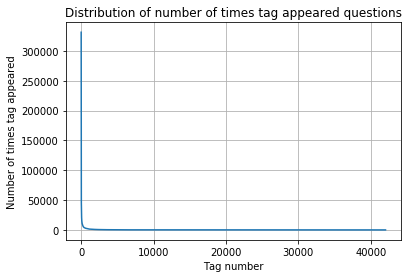

In [17]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

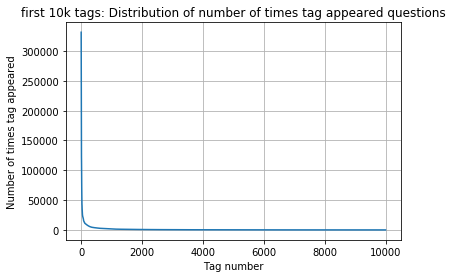

In [18]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

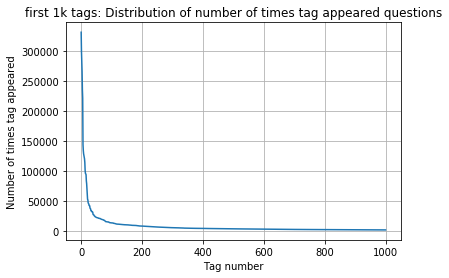

In [19]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

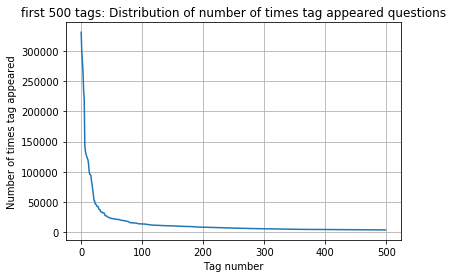

In [20]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

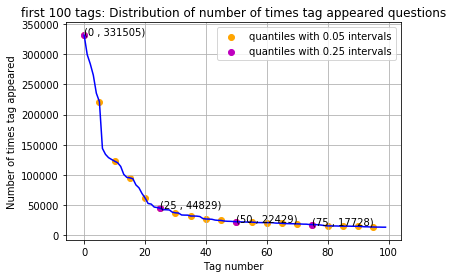

In [21]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()

In [22]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = df_tagfreq[df_tagfreq.Freqs>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = df_tagfreq[df_tagfreq.Freqs>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


Observations:
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this problem.

In [23]:
tag_count = df_train_dedup["tag_count"]

In [24]:
print( "Maximum number of tags per question: %d"%max(tag_count))
print( "Minimum number of tags per question: %d"%min(tag_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_count)*1.0)/len(tag_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899443


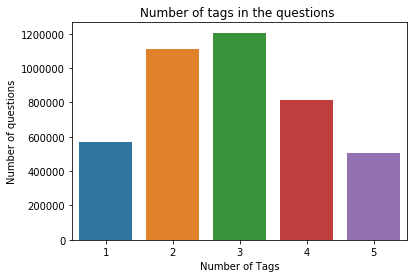

In [25]:
sns.countplot(tag_count)
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

Observations:
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

In [26]:
subset = df_tagfreq[['Tags', 'Freqs']]
tuples = [tuple(x) for x in subset.values]
tuples = dict(tuples)

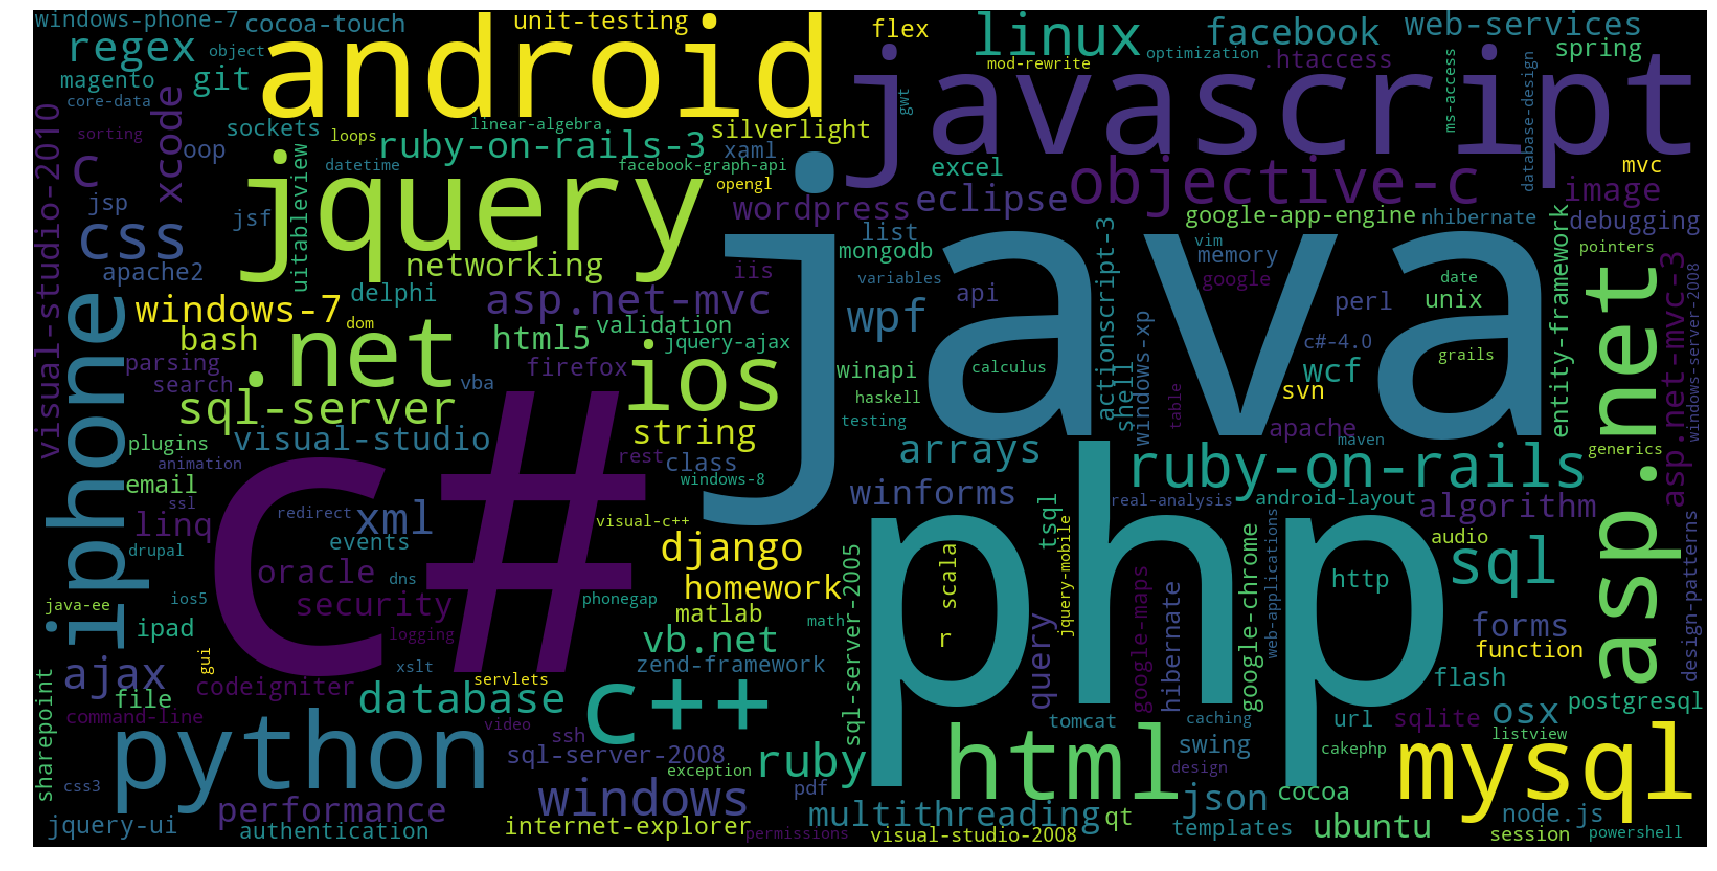

In [27]:
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tuples)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

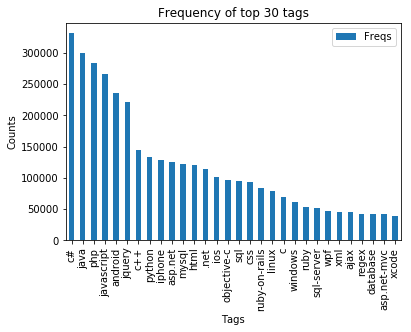

In [28]:
x=np.arange(30)
df_tagfreq_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 30 tags')
plt.xticks(x, df_tagfreq_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

Observations:

1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

Preprocessing 

1.Sample 1M data points 
2. Separate out code-snippets from Body 
3. Remove Spcial characters from Question title and description (not in code)
4. Remove stop words (Except 'C') 
5. Remove HTML Tags 
6. Convert all the characters into small letters 
7. Use SnowballStemmer to stem the words

In [29]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [30]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext

def cleanpunc(data):
    cleandata = re.sub(r'[^A-Za-z]+',r' ',data)
    cleandata = re.sub(r'[?|!|\'|"|#]',r'',cleandata)
    cleandata = re.sub(r'[.|,|)|(|/|\|<|>|:|;|{|}|*|&|^|%|$|!]',r'',cleandata)
    return cleandata

In [31]:
# try out code

subdata = df_train_dedup.head(500000)
Questions = []

for title, body in zip(subdata["Title"].values, subdata["Body"].values):
    code = str(re.findall(r'<code>(.*?)</code>', body, flags=re.DOTALL))
    
    body = re.sub('<code>(.*?)</code>', '', body, flags=re.MULTILINE|re.DOTALL)
    
    body = striphtml(body)
    
    title = striphtml(title)
    
    body = cleanpunc(body)
    
    title = cleanpunc(title)
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+str(body)
    
    question = cleanpunc(question)
    
    words = word_tokenize(str(question.lower())) 
    
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    Questions.append(question)

In [32]:
subdata["Question"] = Questions

In [33]:
subdata

,Id,Title,Body,Tags,tag_count,Question
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5,check upload file imag without mime type check...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1,prevent firefox close press ctrl prevent firef...
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3,error invalid type list variabl error invalid ...
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3,replac special charact url replac special char...
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents,3,modifi whoi contact detail modifi whoi contact...
5,6,setting proxy in active directory environment,<p>I am using a machine on which active direct...,proxy active-directory jmeter,3,set proxi activ directori environ set proxi ac...
6,7,How to draw barplot in this way with Coreplot,<p>My image is cannot post so the link is my ...,core-plot,1,draw barplot way coreplot draw barplot way cor...
7,8,How to fetch an XML feed using asp.net,<p>I've decided to convert a Windows Phone 7 a...,c# asp.net windows-phone-7,3,fetch xml feed use asp net fetch xml feed use ...
8,9,.NET library for generating javascript?,<p>Do you know of a .NET library for generatin...,.net javascript code-generation,3,net librari generat javascript net librari gen...
9,10,"SQL Server : procedure call, inline concatenat...",<p>I'm using SQL Server 2008 R2 and was wonder...,sql variables parameters procedure calls,5,sql server procedur call inlin concaten imposs...


In [34]:
subdata = subdata[["Question","Tags"]]
subdata.head()

,Question,Tags
0,check upload file imag without mime type check...,php image-processing file-upload upload mime-t...
1,prevent firefox close press ctrl prevent firef...,firefox
2,error invalid type list variabl error invalid ...,r matlab machine-learning
3,replac special charact url replac special char...,c# url encoding
4,modifi whoi contact detail modifi whoi contact...,php api file-get-contents


In [35]:
print("number of data points in sample :", subdata.shape[0])
print("number of dimensions :", subdata.shape[1])

number of data points in sample : 500000
number of dimensions : 2


In [36]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(subdata['Tags'])

In [37]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [38]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = subdata.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

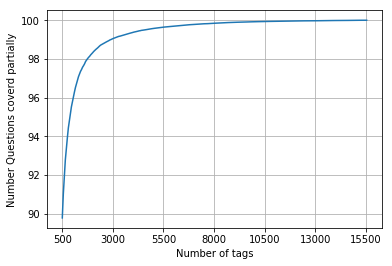

with  5500 tags we are covering  99.049 % of questions
with  500 tags we are covering  89.782 % of questions


In [39]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")